In [1]:
%matplotlib inline

A few basic libraries that we'll need for the initial exercises:

In [2]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
import pandas as pd
#np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

#from numpy.random import random, permutation
#from scipy import misc, ndimage
#from scipy.ndimage.interpolation import zoom

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

'''
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
'''

'\nimport keras\nfrom keras import backend as K\nfrom keras.utils.data_utils import get_file\nfrom keras.models import Sequential, Model\nfrom keras.layers.core import Flatten, Dense, Dropout, Lambda\nfrom keras.layers import Input\nfrom keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D\nfrom keras.optimizers import SGD, RMSprop\nfrom keras.preprocessing import image\n'

In [21]:
import os, sys
current_dir = os.getcwd()

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [25]:
#Create references to important directories we will use over and over
HOME_DIR = current_dir
DATA_HOME_DIR = HOME_DIR + '/data/titanic/'

Set up kaggle config for this competition (after agreeing to rules).

In [14]:
#!kg config -g -u `username` -p `password` 

##dogs-vs-cats-redux-kernels-edition
##state-farm-distracted-driver-detection
##titanic
#!kg config -c 'titanic'

#%cd data/titanic
#!wget https://www.kaggle.com/c/titanic/download/test.csv
#!wget https://www.kaggle.com/c/titanic/download/gender_submission.csv
#!wget https://www.kaggle.com/c/titanic/download/train.csv

/home/adam/kaggle/data/titanic
--2017-09-26 11:20:35--  https://www.kaggle.com/c/titanic/download/test.csv
Resolving www.kaggle.com (www.kaggle.com)... 168.62.224.124
Connecting to www.kaggle.com (www.kaggle.com)|168.62.224.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?ReturnUrl=%2fc%2ftitanic%2fdownload%2ftest.csv [following]
--2017-09-26 11:20:36--  https://www.kaggle.com/account/login?ReturnUrl=%2fc%2ftitanic%2fdownload%2ftest.csv
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 15567 (15K) [text/html]
Saving to: ‘test.csv’

test.csv            100%[===================>]  15.20K  --.-KB/s    in 0.07s   

2017-09-26 11:20:36 (233 KB/s) - ‘test.csv’ saved [15567/15567]

--2017-09-26 11:20:36--  https://www.kaggle.com/c/titanic/download/gender_submission.csv
Resolving www.kaggle.com (www.kaggle.com)... 168.62.224.124
Connecting to www.kaggle.com (www.kaggle.com)|168.62.224.124|:

### Data set-up

Split training and validation set such that a percentage of drivers in the validation set are not in the training set.


In [35]:
## Read names of training images from .csv file
%cd $DATA_HOME_DIR/

train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

other_data=pd.read_csv('gender_submission.csv')


In [57]:
# Designate training/validation data sets
rand_samp = np.random.uniform(0, 1, len(train_data))
train_data['train'] = rand_samp <= .85
train_data['valid'] = rand_samp < .85

# Create two new dataframes, one with the training rows, one with the test rows
train, validate = train_data[train_data['train']], train_data[train_data['valid']]

y = pd.factorize(train['Survived'])[0]

# Create a list of the feature column's names
features = train.loc[:, train.columns != 'Survived'].columns

# View features
print(features)
print(y)

Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked', u'train', u'valid'],
      dtype='object')
[0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0
 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0
 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1
 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1
 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0
 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1
 0 

#### Train Random Forest Classifier

In [59]:
train[features]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train,valid
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,True
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,True,True
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,True,True
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,True,True
11,12,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,True,True
13,14,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,True,True
14,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,True,True


In [58]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[features], y)

ValueError: could not convert string to float: Q

In [10]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [11]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [12]:
vgg = Vgg16()

#vgg.model.load_weights(results_path+'mod_wts.h5')

### Create batches

In [13]:
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
#(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
#    test_filename) = vgg.get_classes(PROJ_HOME_DIR)

# Adapt model to our data
vgg.finetune(batches)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


### Train

In [19]:
vgg.model.optimizer.lr = 1e-5
vgg.fit(batches, val_batches, nb_epoch=2)
vgg.model.optimizer.lr = 1e-3
vgg.fit(batches, val_batches, nb_epoch=4)
vgg.model.save_weights(results_path+'mod_wts.h5')

Epoch 1/2
1500/1500 [==============================] - 63s - loss: 1.0150 - acc: 0.6600 - val_loss: 1.4511 - val_acc: 0.5160
Epoch 2/2
1500/1500 [==============================] - 62s - loss: 0.9597 - acc: 0.6980 - val_loss: 1.4982 - val_acc: 0.4880
Epoch 1/4
1500/1500 [==============================] - 63s - loss: 0.9322 - acc: 0.6967 - val_loss: 1.5244 - val_acc: 0.5230
Epoch 2/4
1500/1500 [==============================] - 63s - loss: 0.8592 - acc: 0.7093 - val_loss: 1.5353 - val_acc: 0.5010
Epoch 3/4
1500/1500 [==============================] - 63s - loss: 0.8520 - acc: 0.7160 - val_loss: 1.6072 - val_acc: 0.4640
Epoch 4/4
1500/1500 [==============================] - 63s - loss: 0.8679 - acc: 0.7080 - val_loss: 1.6114 - val_acc: 0.5010


<CudaNdarrayType(float32, scalar)>


In [17]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Test

In [ ]:
batches, preds = vgg.test(test_path, batch_size = batch_size)
#batches, preds = vgg.test(test_path, batch_size = batch_size*2)
filenames = batches.filenames

#Save our test results arrays so we can use them again later
utils.save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [ ]:
print(preds[:5])

print(filenames[:5])

#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + 'unknown/'+ filenames[2])

In [13]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

Found 2000 images belonging to 2 classes.


[[981  19]
 [ 23 977]]


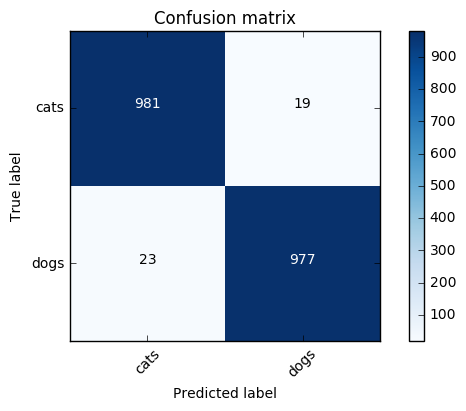

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
utils.plot_confusion_matrix(cm, val_batches.class_indices)


### Create .csv file for submission to Kaggle
For each image in the test set, you should predict a probability that the image is a dog (1.0 = dog, 0.0 = cat).

e.g. [['id', 'label'],[1,0.5],[2,0.5],[3,0.5],...]

In [24]:
input_ids = [int(x[len('unknown/'):-len('.jpg')]) for x in batches.filenames]
    
list_out = sorted(zip(input_ids,np.clip(preds[:,1],0.05,0.95)))

list_out = [('id','label')]+list_out # add column labels

print(list_out[:15])

[('id', 'label'), (1, 0.94999999), (2, 0.94999999), (3, 0.94999999), (4, 0.94999999), (5, 0.050000001), (6, 0.050000001), (7, 0.050000001), (8, 0.050000001), (9, 0.050000001), (10, 0.050000001), (11, 0.050000001), (12, 0.94999999), (13, 0.050000001), (14, 0.050000001)]


In [25]:
import csv

with open("data/dogscats/kaggle/dogscats_predictions4.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(list_out)

In [26]:
! kg submit data/dogscats/kaggle/dogscats_predictions4.csv

Starting new HTTPS connection (1): www.kaggle.com



### Create linear model

In [ ]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)